##Load Dataset


In [154]:
import pandas as pd
from scipy.sparse import hstack,vstack
data=pd.read_csv("stock_data.csv")
data.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [155]:
data["Sentiment"].value_counts()

 1    3685
-1    2106
Name: Sentiment, dtype: int64

In [156]:
data["Sentiment"]=data["Sentiment"].replace({1:2,-1:1})

In [157]:
data1=pd.read_csv("all-data.csv",encoding="ISO-8859-1",header=None,names=["Sentiment","Text"])
data1.shape

(4846, 2)

In [158]:
data1.head()

,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [159]:
data1["Sentiment"].value_counts()

neutral     2879
positive    1363
negative     604
Name: Sentiment, dtype: int64

In [160]:
data1['Sentiment']=data1["Sentiment"].replace({"neutral":0,"positive":2,"negative":1})

In [161]:
frames=[data,data1]

In [162]:
result = pd.concat(frames)

In [163]:
result.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,2
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,2
2,user I'd be afraid to short AMZN - they are lo...,2
3,MNTA Over 12.00,2
4,OI Over 21.37,2


In [164]:
result['Sentiment'].value_counts()

2    5048
0    2879
1    2710
Name: Sentiment, dtype: int64

##Train Test Split

In [165]:
from sklearn.model_selection import train_test_split

In [166]:
x=result.drop("Sentiment",axis=1)
y=result['Sentiment']

In [167]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,stratify=y,random_state=21)

In [168]:
print("Total train data",x_train.shape[0])

Total train data 8509


In [169]:
print("Total test data",x_test.shape[0])

Total test data 2128


In [170]:
y_train.value_counts()

2    4038
0    2303
1    2168
Name: Sentiment, dtype: int64

In [171]:
y_test.value_counts()

2    1010
0     576
1     542
Name: Sentiment, dtype: int64

In [172]:
x_train

,Text
3034,Microsoft last week also issued the first patc...
4830,HAO like it on a pop over 6 w vol
814,"According to CEO Kai Telanne , the company 's ..."
4390,"As capacity was cut with 1.4 % , the passenger..."
2246,These measures are expected to produce annual ...
...,...
3027,Mercator will use the software for its logisti...
1608,IMM lol AAP-tlye presentation - get creative guys
668,CS will play lower
5095,"Citing improved money-market conditions, the b..."


##preprocessing

In [173]:
import numpy as np

In [174]:
def preprocessing(data):
  data["Text"].replace("[^0-9a-zA-Z]"," ",regex=True, inplace=True)
  df=[]


  for i in range(data.values.shape[0]):
    df.append(np.char.lower(data["Text"].values[i]))
  return np.array(df)


In [175]:
x_tr=preprocessing(x_train)
x_te=preprocessing(x_test)

In [176]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
val = vectorizer.fit_transform(x_tr)
idf = vectorizer.idf_
idf_values=dict(zip(vectorizer.get_feature_names(), idf))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [177]:
data=pd.DataFrame(data=idf_values.values(),index=idf_values.keys(),columns=["idf"])


In [178]:
data.head()

,idf
00,5.464030
000,4.937009
000063,9.355850
000x,9.355850
002,9.355850


In [179]:
print(max(idf_values.values()))


9.355850041007475


In [180]:
print(min(idf_values.values()))

1.7627277687843543


In [181]:
data.describe()

,idf
count,14665.000000
mean,8.744558
std,0.948589
min,1.762728
25%,8.439559
50%,9.355850
75%,9.355850
max,9.355850


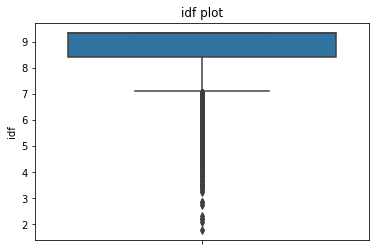

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(y="idf",data=data)
plt.title("idf plot")
plt.show()


In [183]:
words={}
for word,val in idf_values.items():
  if val>=3 and val<=10:
    words[word]=val

In [184]:
tr_essay=[]
for sentence in x_tr:
  tr=[]
  for word in sentence.split():
    if word in words.keys():
      tr.append(word)
  c=" ".join(tr)
  tr_essay.append(c)

In [185]:
trn_essay=np.array(tr_essay)
print(trn_essay.shape)

(8509,)


In [186]:
te_essay=[] #get only words of required idf
for sentence in x_te:
  tr=[]
  for word in sentence.split():
    if word in words.keys():
      tr.append(word)
  c=" ".join(tr)
  te_essay.append(c)


In [187]:
ten_essay=np.array(te_essay)
print(ten_essay.shape)

(2128,)


In [188]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def sen(df):
  """
  This function takes dataframe as input 
  and gives sentimental scores of 
  positive,negative,neutral and compound scores
  for each essays
  """
  sid = SentimentIntensityAnalyzer()
  neg=[]
  neu=[]
  pos=[]
  compound=[]
  for row in df:
     ss = sid.polarity_scores(row)
     neg.append(ss['neg'])
     neu.append(ss['neu'])
     pos.append(ss['pos'])
     compound.append(ss['compound'])
  return np.array(neg),np.array(neu),np.array(pos),np.array(compound)

In [189]:
#import nltk
#nltk.download('vader_lexicon')

In [190]:
tr_neg,tr_neu,tr_pos,tr_co=sen(trn_essay)
te_neg,te_neu,te_pos,te_co=sen(ten_essay)

In [191]:

tfidf_model = TfidfVectorizer()
tfidf_model.fit(trn_essay)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [192]:
import pickle

In [193]:
with open('/content/drive/MyDrive/6_Donors_choose_NB/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [194]:
def tfidf_w2v(df):
 """
  This takes dataframe as input 
  and returns tfidf weighted w2v vectors 
  of length 300
 """
 tfidf_w2v_vectors = [];
 for sentence in df:
    vector = np.zeros(300) 
    tf_idf_weight =0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)
 return np.array(tfidf_w2v_vectors)

In [195]:
es_tr=tfidf_w2v(trn_essay)
es_te=tfidf_w2v(ten_essay)

In [196]:
x_tr=np.hstack((es_tr,tr_neu.reshape(-1,1),tr_neg.reshape(-1,1),tr_pos.reshape(-1,1),tr_co.reshape(-1,1)))

In [197]:
x_te=np.hstack((es_te,te_neu.reshape(-1,1),te_neg.reshape(-1,1),te_pos.reshape(-1,1),te_co.reshape(-1,1)))

##ML models

In [221]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [199]:
import sklearn

In [242]:
#Grid search On Decision Tree with max depth and min samples split as hyper paramteres
dt= DecisionTreeClassifier(random_state=15)
parameters = { 'max_depth':[1, 5, 10, 50], 'min_samples_split':[5, 10,20,30,40,50]}
clf = GridSearchCV(dt, parameters, cv=3, scoring="accuracy",return_train_score=True ,verbose=2)
clf.fit(x_tr, y_train)
results = pd.DataFrame.from_dict(clf.cv_results_)
results

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END ...................max_depth=1, min_samples_split=5; total time=   0.4s
[CV] END ...................max_depth=1, min_samples_split=5; total time=   0.4s
[CV] END ...................max_depth=1, min_samples_split=5; total time=   0.4s
[CV] END ..................max_depth=1, min_samples_split=10; total time=   0.4s
[CV] END ..................max_depth=1, min_samples_split=10; total time=   0.4s
[CV] END ..................max_depth=1, min_samples_split=10; total time=   0.4s
[CV] END ..................max_depth=1, min_samples_split=20; total time=   0.4s
[CV] END ..................max_depth=1, min_samples_split=20; total time=   0.3s
[CV] END ..................max_depth=1, min_samples_split=20; total time=   0.3s
[CV] END ..................max_depth=1, min_samples_split=30; total time=   0.3s
[CV] END ..................max_depth=1, min_samples_split=30; total time=   0.3s
[CV] END ..................max_depth=1, min_samp

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.361622,0.008687,0.004504,0.000133,1,5,"{'max_depth': 1, 'min_samples_split': 5}",0.519915,0.517278,0.522920,0.520038,0.002305,14,0.519217,0.523533,0.527587,0.523446,0.003417
1,0.370196,0.014518,0.004402,0.000058,1,10,"{'max_depth': 1, 'min_samples_split': 10}",0.519915,0.517278,0.522920,0.520038,0.002305,14,0.519217,0.523533,0.527587,0.523446,0.003417
2,0.311914,0.043135,0.003630,0.000525,1,20,"{'max_depth': 1, 'min_samples_split': 20}",0.519915,0.517278,0.522920,0.520038,0.002305,14,0.519217,0.523533,0.527587,0.523446,0.003417
3,0.272640,0.002485,0.003107,0.000011,1,30,"{'max_depth': 1, 'min_samples_split': 30}",0.519915,0.517278,0.522920,0.520038,0.002305,14,0.519217,0.523533,0.527587,0.523446,0.003417
4,0.273385,0.001962,0.003205,0.000094,1,40,"{'max_depth': 1, 'min_samples_split': 40}",0.519915,0.517278,0.522920,0.520038,0.002305,14,0.519217,0.523533,0.527587,0.523446,0.003417
5,0.274094,0.001356,0.003141,0.000037,1,50,"{'max_depth': 1, 'min_samples_split': 50}",0.519915,0.517278,0.522920,0.520038,0.002305,14,0.519217,0.523533,0.527587,0.523446,0.003417
6,1.154971,0.012662,0.003368,0.000079,5,5,"{'max_depth': 5, 'min_samples_split': 5}",0.573493,0.578984,0.573695,0.575391,0.002542,2,0.641220,0.633175,0.640226,0.638207,0.003581
7,1.158462,0.003150,0.003362,0.000074,5,10,"{'max_depth': 5, 'min_samples_split': 10}",0.573493,0.578984,0.573695,0.575391,0.002542,2,0.641220,0.633175,0.640226,0.638207,0.003581
8,1.156270,0.011303,0.003311,0.000015,5,20,"{'max_depth': 5, 'min_samples_split': 20}",0.573493,0.578984,0.572990,0.575156,0.002715,4,0.641220,0.633175,0.639697,0.638031,0.003489
9,1.151523,0.007796,0.003464,0.000022,5,30,"{'max_depth': 5, 'min_samples_split': 30}",0.573493,0.578984,0.572990,0.575156,0.002715,4,0.641220,0.633175,0.639697,0.638031,0.003489


In [243]:
cv_result = pd.DataFrame(clf.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
11,"{'max_depth': 5, 'min_samples_split': 50}",0.575509,1
6,"{'max_depth': 5, 'min_samples_split': 5}",0.575391,2
7,"{'max_depth': 5, 'min_samples_split': 10}",0.575391,2
8,"{'max_depth': 5, 'min_samples_split': 20}",0.575156,4
9,"{'max_depth': 5, 'min_samples_split': 30}",0.575156,4
10,"{'max_depth': 5, 'min_samples_split': 40}",0.575156,4
12,"{'max_depth': 10, 'min_samples_split': 5}",0.547538,7
17,"{'max_depth': 10, 'min_samples_split': 50}",0.546714,8
13,"{'max_depth': 10, 'min_samples_split': 10}",0.545070,9
15,"{'max_depth': 10, 'min_samples_split': 30}",0.543659,10


In [244]:
depth1=5
min_samples_split1=50
#fit with best paramteres
dt= DecisionTreeClassifier(max_depth=depth1,min_samples_split=min_samples_split1,random_state=15)
dt.fit(x_tr, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=50, random_state=15)

In [246]:
y_pre=dt.predict(x_te)
total=y_test.shape[0]

In [247]:
res=sum(y_pre==y_test)
print("Accuracy",res/total)

Accuracy 0.5972744360902256


In [248]:
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False,random_state=15)
parameters = { 'max_depth':[3,6,9], 'n_estimators':[100,200,300]}
clf = GridSearchCV(model, parameters, cv=3,scoring='accuracy',return_train_score=True,verbose=2)
clf.fit(x_tr, y_train)
results = pd.DataFrame.from_dict(clf.cv_results_)
results.head()

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......................max_depth=3, n_estimators=100; total time=  34.2s
[CV] END ......................max_depth=3, n_estimators=100; total time=  34.6s
[CV] END ......................max_depth=3, n_estimators=100; total time=  33.0s
[CV] END ......................max_depth=3, n_estimators=200; total time= 1.1min
[CV] END ......................max_depth=3, n_estimators=200; total time= 1.1min
[CV] END ......................max_depth=3, n_estimators=200; total time= 1.1min
[CV] END ......................max_depth=3, n_estimators=300; total time= 1.7min
[CV] END ......................max_depth=3, n_estimators=300; total time= 1.6min
[CV] END ......................max_depth=3, n_estimators=300; total time= 1.6min
[CV] END ......................max_depth=6, n_estimators=100; total time= 1.2min
[CV] END ......................max_depth=6, n_estimators=100; total time= 1.1min
[CV] END ......................max_depth=6, n_est

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,33.885305,0.681887,0.049709,0.000271,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.670779,0.676657,0.670663,0.672700,0.002799,9,0.808181,0.806980,0.807686,0.807615,0.000492
1,65.808483,0.655826,0.087587,0.005006,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.683821,0.687588,0.690409,0.687273,0.002699,7,0.892278,0.888419,0.889124,0.889940,0.001678
2,99.255499,2.319552,0.128970,0.015791,3,300,"{'max_depth': 3, 'n_estimators': 300}",0.692281,0.697109,0.692172,0.693854,0.002302,5,0.943054,0.942887,0.942711,0.942884,0.000140
3,69.033689,0.288525,0.081460,0.001547,6,100,"{'max_depth': 6, 'n_estimators': 100}",0.692633,0.689351,0.696051,0.692678,0.002735,6,0.999118,0.998590,0.998414,0.998707,0.000300
4,139.056255,1.233992,0.181682,0.002283,6,200,"{'max_depth': 6, 'n_estimators': 200}",0.703560,0.696403,0.697814,0.699259,0.003095,3,0.999647,0.999471,0.999471,0.999530,0.000083


In [249]:
cv_result = pd.DataFrame(clf.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
5,"{'max_depth': 6, 'n_estimators': 300}",0.700904,1
8,"{'max_depth': 9, 'n_estimators': 300}",0.699730,2
4,"{'max_depth': 6, 'n_estimators': 200}",0.699259,3
7,"{'max_depth': 9, 'n_estimators': 200}",0.694911,4
2,"{'max_depth': 3, 'n_estimators': 300}",0.693854,5
3,"{'max_depth': 6, 'n_estimators': 100}",0.692678,6
1,"{'max_depth': 3, 'n_estimators': 200}",0.687273,7
6,"{'max_depth': 9, 'n_estimators': 100}",0.685509,8
0,"{'max_depth': 3, 'n_estimators': 100}",0.672700,9


In [250]:
clf.best_params_


{'max_depth': 6, 'n_estimators': 300}

In [254]:
depth1=6
min_samples_split1=300


#fit with best paramteres
dt= XGBClassifier(max_depth=depth1,min_samples_split=min_samples_split1,random_state=15)

dt.fit(x_tr, y_train)



XGBClassifier(max_depth=6, min_samples_split=300, objective='multi:softprob',
              random_state=15)

In [255]:
y_pre=dt.predict(x_te)
total=y_test.shape[0]

In [256]:
res=sum(y_pre==y_test)
print("Accuracy",res/total)

Accuracy 0.6875


In [ ]:
rf_clf = RandomForestClassifier(random_state=42)

parameters = {
    'n_estimators': (50,100,200,300),
    'max_depth':(5,7,9,10)
}
rf_clf_gridcv = GridSearchCV(rf_clf, parameters, cv=3, 
                                     scoring='accuracy',verbose=2)
rf_clf_gridcv.fit(x_tr, y_train)

In [229]:
cv_result = pd.DataFrame(rf_clf_gridcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
14,"{'max_depth': 10, 'n_estimators': 200}",0.645903,1
15,"{'max_depth': 10, 'n_estimators': 300}",0.645785,2
10,"{'max_depth': 9, 'n_estimators': 200}",0.645315,3
9,"{'max_depth': 9, 'n_estimators': 100}",0.644729,4
13,"{'max_depth': 10, 'n_estimators': 100}",0.644258,5
11,"{'max_depth': 9, 'n_estimators': 300}",0.643435,6
8,"{'max_depth': 9, 'n_estimators': 50}",0.639440,7
12,"{'max_depth': 10, 'n_estimators': 50}",0.633445,8
5,"{'max_depth': 7, 'n_estimators': 100}",0.629803,9
6,"{'max_depth': 7, 'n_estimators': 200}",0.628510,10


In [232]:
y_pre = rf_clf_gridcv.best_estimator_.predict(x_te)

In [233]:
res=sum(y_pre==y_test)
print("Accuracy",res/total)

Accuracy 0.644266917293233
